In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [3]:
from scipy import io as spio
emnist = spio.loadmat("./matlab/emnist-balanced.mat")

In [4]:
# load training dataset
emnist_train_images = emnist["dataset"][0][0][0][0][0][0]
emnist_train_images = emnist_train_images.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [5]:
# load test dataset
emnist_test_images = emnist["dataset"][0][0][1][0][0][0]
emnist_test_images = emnist_test_images.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [6]:
emnist_train_images.shape

(112800, 784)

In [7]:
y_train.shape

(112800, 1)

In [8]:
# reshape using matlab order
x_train = emnist_train_images.reshape(emnist_train_images.shape[0], 1, 28, 28, order="A")
x_test = emnist_test_images.reshape(emnist_test_images.shape[0], 1, 28, 28, order="A")
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train /= 255
x_test /= 255

In [9]:
x_train.shape

(112800, 28, 28, 1)

In [10]:
# labels should be onehot encoded
y_train = tf.keras.utils.to_categorical(y_train, 47)
y_test = tf.keras.utils.to_categorical(y_test, 47)

y_train.shape

(112800, 47)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


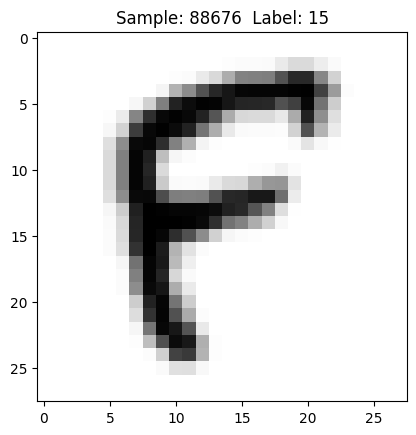

In [11]:
def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(y_train[num])  
    #Print the label converted back to a number
    label = y_train[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(88676)

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.2))
# Flatten the results to one dimension
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# Another dropout
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# Final categorization with softmax
model.add(Dense(47, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

2023-05-21 20:57:36.567921: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 20:57:36.568222: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [13]:
# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint("./best_model", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

# stop model training early if validation loss doesn't continue to decrease over 5 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")

# create list of callbacks
callbacks_list = [checkpoint, early_stopping]

# compile model
model.compile(optimizer="adam",loss=categorical_crossentropy, metrics=["accuracy"])

# train and save model
history = model.fit(x_train, 
          y_train, 
          epochs=20, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          callbacks=callbacks_list, 
          verbose=1)
model.save("./model")
print("model saved")

Train on 112800 samples, validate on 18800 samples
Epoch 1/20
112640/112800 [============================>.] - ETA: 0s - loss: 0.9141 - accuracy: 0.7203
Epoch 00001: val_accuracy improved from -inf to 0.83628, saving model to ./best_model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2023-05-21 21:02:24.222215: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./best_model/assets
112800/112800 [==============================] - 288s 3ms/sample - loss: 0.9136 - accuracy: 0.7204 - val_loss: 0.4804 - val_accuracy: 0.8363
Epoch 2/20
112640/112800 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8392
Epoch 00002: val_accuracy improved from 0.83628 to 0.86149, saving model to ./best_model
INFO:tensorflow:Assets written to: ./best_model/assets
112800/112800 [==============================] - 291s 3ms/sample - loss: 0.4648 - accuracy: 0.8392 - val_loss: 0.4045 - val_accuracy: 0.8615
Epoch 3/20
112640/112800 [============================>.] - ETA: 1s - loss: 0.4015 - accuracy: 0.8583
Epoch 00003: val_accuracy improved from 0.86149 to 0.86947, saving model to ./best_model
INFO:tensorflow:Assets written to: ./best_model/assets
112800/112800 [==============================] - 1238s 11ms/sample - loss: 0.4016 - accuracy: 0.8583 - val_loss: 0.3754 - val_accuracy: 0.8695
Epoch 4/20
112640/112800 [==